In [1]:

from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
from diffusers import DiffusionPipeline, StableDiffusionPipeline
import torch
import numpy as np
from compel import Compel, ReturnedEmbeddingsType
device = "cuda:1"
import os

import glob
from matplotlib import pyplot as plt

def generate(im_name):
    processor = BlipProcessor.from_pretrained("unography/blip-long-cap",cache_dir="/data4/saland/cache")
    model = BlipForConditionalGeneration.from_pretrained("unography/blip-long-cap",cache_dir="/data4/saland/cache").to(device)

    raw_image = Image.open(im_name).convert('RGB')

    inputs = processor(raw_image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values
    out = model.generate(pixel_values=pixel_values, max_length=1000, num_beams=3, repetition_penalty=2.5)
    prompt = processor.decode(out[0], skip_special_tokens=True)
    print(prompt)

    seed = torch.Generator(device='cuda').manual_seed(2)
    pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16").to(device)
    compel = Compel(tokenizer=[pipe.tokenizer, pipe.tokenizer_2] , text_encoder=[pipe.text_encoder, pipe.text_encoder_2], returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED, requires_pooled=[False, True]) 
    conditioning, pooled = compel("a camera highly detailed shot of "+prompt)
    images = pipe(prompt_embeds=conditioning, pooled_prompt_embeds=pooled,num_inference_steps=20).images[0]


    inputs2 = processor(images, return_tensors="pt").to(device)
    pixel_values2 = inputs2.pixel_values
    out2 = model.generate(pixel_values=pixel_values2, max_length=1000, num_beams=3, repetition_penalty=2.5)
    prompt2 = processor.decode(out2[0], skip_special_tokens=True)
    print(prompt2)

    return images

/home/lsaland/micromamba/envs/clip/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/lsaland/micromamba/envs/clip/lib/python3.11/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [2]:
img = generate("../../img/cat.jpg")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


a close - up of a tabby cat's face with striking green eyes. the cat has a mix of brown, black, and white fur, and is positioned in front of a brick or stone surface. the background appears to be an outdoor setting, possibly a garden or patio area. the cat's gaze is focused and attentive, suggesting it might be observing its surroundings. there are no other animals or people visible in the image.


  0%|          | 0/20 [00:00<?, ?it/s]/home/lsaland/micromamba/envs/clip/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 20/20 [00:03<00:00,  5.47it/s]


a close - up of a cat's face with green eyes, positioned in front of a brick wall. the cat has a mix of gray and white stripes on its fur, and is looking directly at the camera. there are no other animals or people visible in the image. the cat appears to be calm and relaxed, possibly observing something outside the frame.


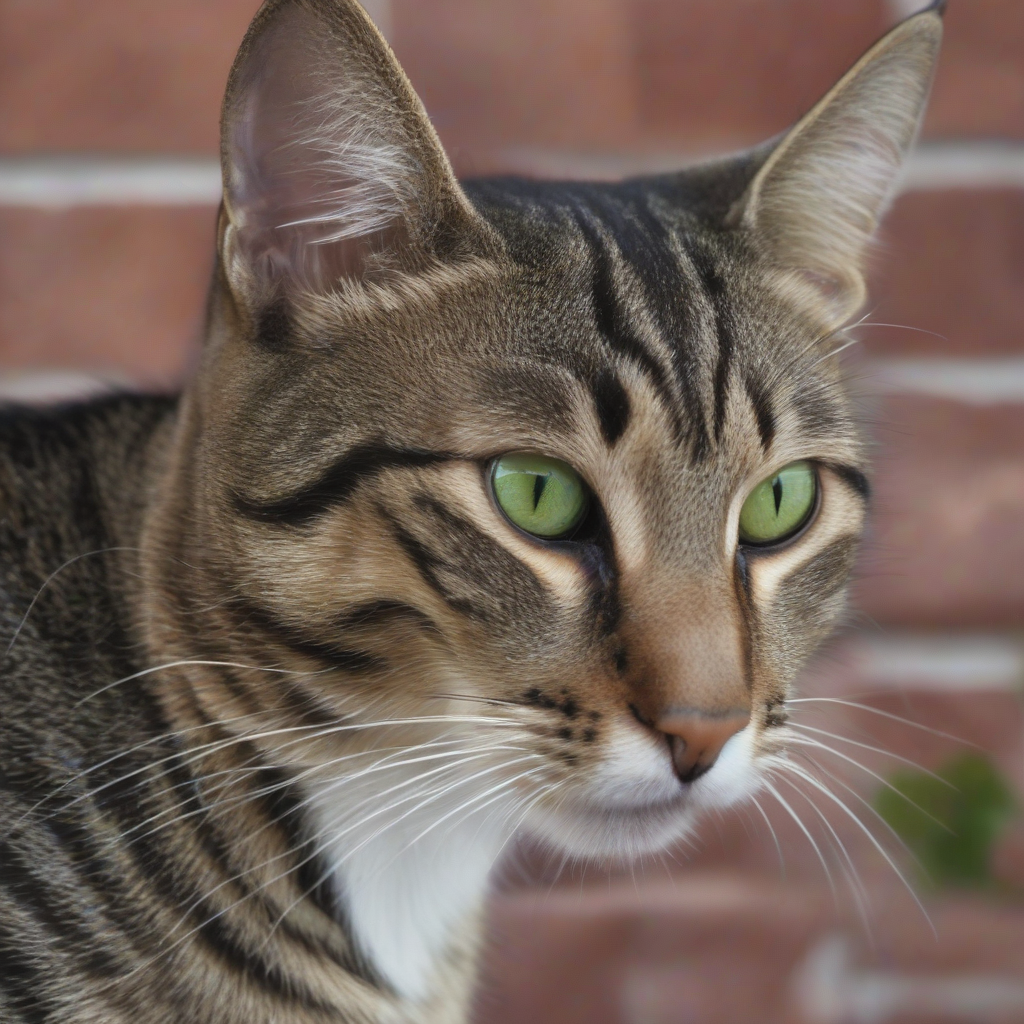

In [3]:
img